In [13]:
import yaml
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
from datetime import datetime
from scipy.stats import pearsonr
import numpy as np
import math

In [132]:
# Load the YAML file
yaml_file_path = Path("/workspace/data/lchu/hls/jobs/1600-fair-bs16-2023-08-20_17-19-05.yaml")  # Replace with the actual path to your YAML file
with open(yaml_file_path, "r") as file:
    yaml_data = yaml.safe_load(file)
training_length = yaml_data["training_length"]
# Access the file path from the YAML data
data_file_path = Path(yaml_data["csv_dir"]) / "chip_stats.csv"
val_cloud_path = Path(yaml_data["csv_dir"]) / "val_cloud_catalog.csv"
save_dir = Path(yaml_data["visualization_dir"])
os.makedirs(save_dir, exist_ok=True)

# Read the .txt file as a CSV using pandas
data_table = pd.read_csv(data_file_path)
val_clouds = pd.read_csv(val_cloud_path)
val_clouds.sort_values(by='fmask_name', inplace=True)

# Display the DataFrame
print(data_table.head())
print(val_clouds.head())

df = pd.concat([data_table.reset_index(drop=True), val_clouds.reset_index(drop=True)], axis=1)
print(df.columns)

        chip_id      chip_x     chip_y   tile  valid_first  valid_second  \
0  chip_002_060 -122.633558  48.932491  10UEV      49903.0       44547.0   
1  chip_021_109 -117.915818  48.565491  11UMP      50094.0       50165.0   
2  chip_026_164 -112.957171  48.949134  12UUV      50176.0       50175.0   
3  chip_027_083 -120.048482  47.830456  10UGU      49294.0       50118.0   
4  chip_031_077 -120.474559  47.502665  10TFT      50167.0       50162.0   

   valid_third  bad_pct_first  bad_pct_second  bad_pct_third  ...   B04 MAE  \
0      49313.0       0.213249        2.841996       0.998485  ...  0.006833   
1      50165.0       0.047832        0.011958       0.009965  ...  0.015290   
2      50176.0       0.000000        0.001993       0.000000  ...  0.008585   
3      49757.0       0.739397        0.033881       0.197305  ...  0.008903   
4      50163.0       0.011958        0.023916       0.023916  ...  0.008530   

    B05 MAE   B07 MAE   B08 MAE  B02 SSIM  B03 SSIM  B04 SSIM  B05 S

In [133]:
df['first_image_date'] = pd.to_datetime(df['first_image_date'])
df['second_image_date'] = pd.to_datetime(df['second_image_date'])
df['third_image_date'] = pd.to_datetime(df['third_image_date'])


# Calculate the difference in days
df['Time Gap'] = (df['third_image_date'] - df['first_image_date']).dt.days
df['Cloud Ratio'] = df['cloud_pct']
df['Overall RMSE'] = np.sqrt(df['Overall MSE'])
df['SSIM Error'] = (1 - df['Overall SSIM']) / df['Cloud Ratio']
print(df.head())
print(df.columns)

        chip_id      chip_x     chip_y   tile  valid_first  valid_second  \
0  chip_002_060 -122.633558  48.932491  10UEV      49903.0       44547.0   
1  chip_021_109 -117.915818  48.565491  11UMP      50094.0       50165.0   
2  chip_026_164 -112.957171  48.949134  12UUV      50176.0       50175.0   
3  chip_027_083 -120.048482  47.830456  10UGU      49294.0       50118.0   
4  chip_031_077 -120.474559  47.502665  10TFT      50167.0       50162.0   

   valid_third  bad_pct_first  bad_pct_second  bad_pct_third  ...  B07 SSIM  \
0      49313.0       0.213249        2.841996       0.998485  ...  0.964773   
1      50165.0       0.047832        0.011958       0.009965  ...  0.800787   
2      50176.0       0.000000        0.001993       0.000000  ...  0.971376   
3      49757.0       0.739397        0.033881       0.197305  ...  0.892561   
4      50163.0       0.011958        0.023916       0.023916  ...  0.944120   

   B08 SSIM                fmask_name  cloud_pct     usage      bin 

In [134]:
columns_to_average = [
    'B02 MSE', 'B03 MSE', 'B04 MSE', 'B05 MSE',
    'B07 MSE', 'B08 MSE', 'B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE',
    'B02 SSIM', 'B03 SSIM', 'B04 SSIM', 'B05 SSIM',
    'B07 SSIM', 'B08 SSIM'
]
mae_list = ['B02 MAE', 'B03 MAE',
    'B04 MAE', 'B05 MAE', 'B07 MAE', 'B08 MAE']
mae_averages = df[mae_list].mean()
means = [mean / 10000 for mean in [495.7316,  814.1386,  924.5740, 2962.5623, 2640.8833, 1740.3031]]
error = mae_averages / means
print(error)
# Calculate column averages
column_averages = df[columns_to_average].mean()

# Print the calculated averages
print(column_averages)

B02 MAE    0.135552
B03 MAE    0.103152
B04 MAE    0.143212
B05 MAE    0.078102
B07 MAE    0.084120
B08 MAE    0.122425
dtype: float64
B02 MSE     0.000158
B03 MSE     0.000241
B04 MSE     0.000589
B05 MSE     0.001556
B07 MSE     0.001507
B08 MSE     0.001480
B02 MAE     0.006720
B03 MAE     0.008398
B04 MAE     0.013241
B05 MAE     0.023138
B07 MAE     0.022215
B08 MAE     0.021306
B02 SSIM    0.959422
B03 SSIM    0.957162
B04 SSIM    0.920607
B05 SSIM    0.871878
B07 SSIM    0.902828
B08 SSIM    0.897272
dtype: float64


             Overall SSIM Overall MAE Cloud Ratio Time Gap
Overall SSIM       1.0***    -0.89***    -0.88***  -0.1***
Overall MAE      -0.89***      1.0***     0.74***   0.2***
Cloud Ratio      -0.88***     0.74***      1.0***    -0.02
Time Gap          -0.1***      0.2***       -0.02   1.0***
              Overall SSIM  Overall MAE  Cloud Ratio  Time Gap
Overall SSIM      1.000000    -0.894323    -0.876260 -0.096348
Overall MAE      -0.894323     1.000000     0.741810  0.198466
Cloud Ratio      -0.876260     0.741810     1.000000 -0.017933
Time Gap         -0.096348     0.198466    -0.017933  1.000000


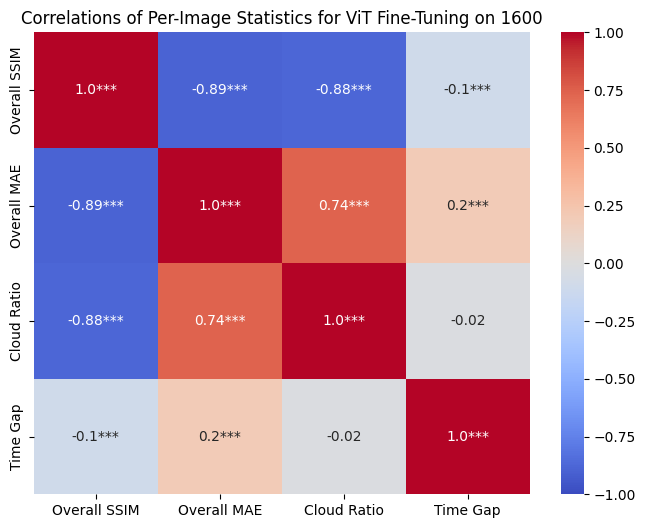

In [131]:
df = df[['Overall SSIM', 'Overall MAE',
       'Cloud Ratio', 'Time Gap']]


rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
significant_correlations = rho.round(2).astype(str) + p
print(significant_correlations)
print(rho)



# Create the heatmap of p-values
plt.figure(figsize=(8, 6))
sns.heatmap(rho, annot=significant_correlations, fmt='', cmap="coolwarm", vmin=-1, vmax=1)  # Format to 3 decimal places
plt.title(f'Correlations of Per-Image Statistics for ViT Fine-Tuning on {training_length}')

plt.savefig(save_dir / 'per_image_correlations.png', format='png')

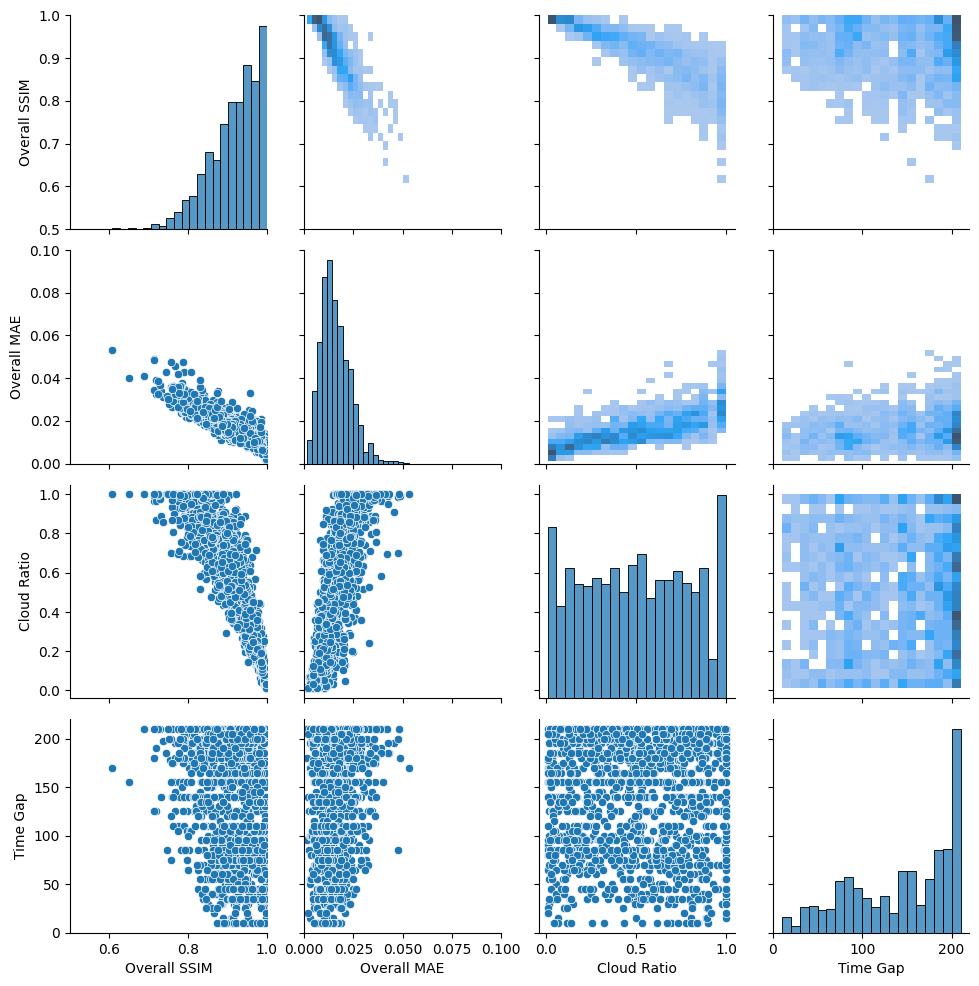

In [127]:
df = df[['Overall SSIM', 'Overall MAE', 'Cloud Ratio', 'Time Gap']]
g = sns.PairGrid(df, diag_sharey=False)

g.map_upper(sns.histplot, bins=20)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, bins=20)

g.axes[0,0].set_xlim(0.5,1)
g.axes[0,0].set_ylim(0.5,1)
g.axes[1,1].set_xlim(0,0.1)
g.axes[1,1].set_ylim(0,0.1)


plt.savefig(save_dir / 'per_image_pairgrid.png', format='png')